In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [3]:
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_intersection_consensus_males_30-50.csv", index_col=0)

In [12]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [13]:
ppmi_ad = ppmi_ad[mask]

In [14]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]


In [15]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [17]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [13]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [14]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.75      0.50      0.60         6

    accuracy                           0.60        10
   macro avg       0.62      0.62      0.60        10
weighted avg       0.65      0.60      0.60        10



In [15]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.708
PR-AUC: 0.841


NameError: name 'y_proba' is not defined

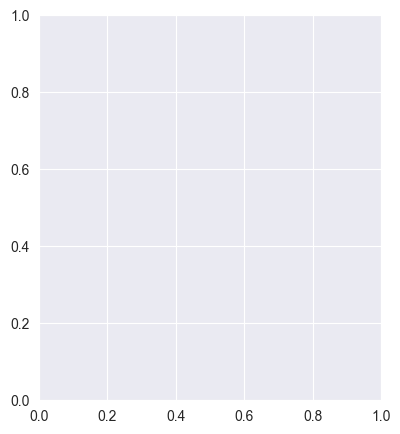

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [22]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.883 ± 0.183
PR-AUC: 0.936 ± 0.116


In [18]:
coefficients = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'coefficient': lr_pipeline.named_steps['lr'].coef_[0],
    'abs_coef': np.abs(lr_pipeline.named_steps['lr'].coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 40 predictive genes:")
print(coefficients.head(40)[['gene_symbol', 'coefficient']])


Top 40 predictive genes:
                        gene_symbol  coefficient
ENSG00000046774.9            MAGEC2    -0.104891
ENSG00000277636.1           MIR8061    -0.099142
ENSG00000213731.2           RAB5CP1    -0.090721
ENSG00000215063.3           RPL21P2    -0.089209
ENSG00000230583.7        GTF2IRD1P1    -0.086553
ENSG00000200556.1         RNU6-103P    -0.079192
ENSG00000265888.1             DSCAS    -0.078117
ENSG00000240973.1      LOC100506489    -0.077080
ENSG00000170802.15            FOXN2    -0.076423
ENSG00000229082.2           OR5AW1P    -0.074248
ENSG00000269181.1   ENSG00000269181    -0.073762
ENSG00000177340.5          FLJ13224    -0.073097
ENSG00000282317.1   ENSG00000282317     0.072896
ENSG00000217631.1   ENSG00000217631    -0.072633
ENSG00000228351.2   ENSG00000228351    -0.072532
ENSG00000263515.1          MIR548AN    -0.071069
ENSG00000270200.1   ENSG00000270200    -0.069578
ENSG00000257955.1   ENSG00000257955     0.068996
ENSG00000227306.1         LINC02708    -0.0

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_18653/888752835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


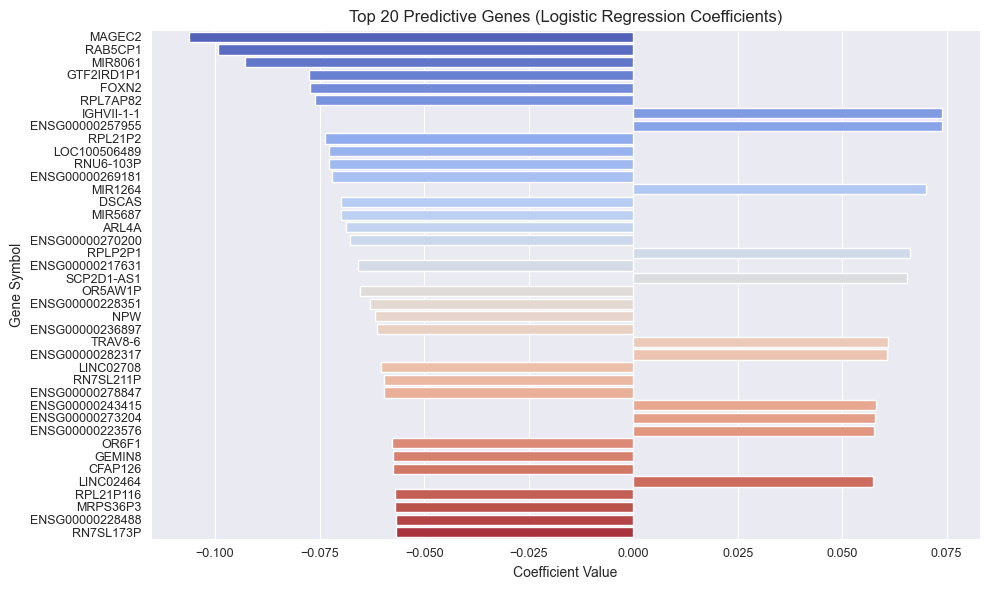

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients.head(40),
    x='coefficient',
    y='gene_symbol',
    palette='coolwarm'
)
plt.title('Top 20 Predictive Genes (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Precision-Recall Tradeoff (best for imbalanced data)

In [19]:
optimal_idx = np.argmax(precision * recall)
optimal_threshold_pr = thresholds[optimal_idx]
print(f"Optimal PR Threshold: {optimal_threshold_pr:.3f}")

Optimal PR Threshold: 0.124


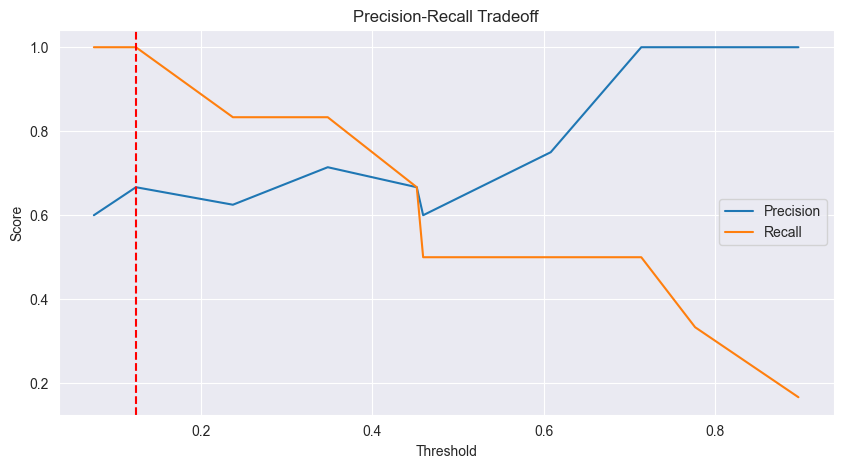

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [44]:
final_threshold = optimal_threshold_pr
y_pred_custom = (y_proba >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10

ROC-AUC: 0.958


In [45]:
y_pred_custom

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [46]:
y_proba

array([9.99948294e-01, 2.69027376e-02, 9.99935072e-01, 2.15013449e-07,
       7.28956514e-05, 1.59122278e-02, 9.99961485e-01, 9.99939536e-01,
       5.06101700e-08, 9.99944119e-01])